# Principal Component Analysis (PCA) 

## Learning objectives

- 1. Understanding and interpreting the correlation between different features of a dataset.
- 2. Applying PCA on a real world dataset and understanding how much data is stored in which components.
- 3. Visualizing high dimensional data by first reducing it to two dimensions by using PCA and then plotting it.
- 4. Observing how the performance of a model varies with the number of principle components used.

Two of the uses of PCA are to visualize high dimensional datasets and improve the training speed of machine learning models. In this notebook, we will demonstrate how PCA helps us with both of these.

In [ ]:
%ls


In [ ]:
%pwd


# Part 1

Let's generate some x,y data, reshape these, calculate the correlation matrix, eigenvalues of the matrix, eigenvectors, 
and analyse the distribution of scatter plots

[[-0.31532243 -0.9489846 ]
 [-0.9489846   0.31532243]]


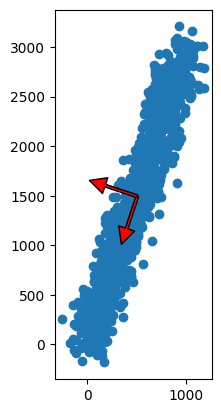

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
xTrue = np.linspace(0, 1000, N)
yTrue = 3 * xTrue
xData = xTrue + np.random.normal(0, 100, N)
yData = yTrue + np.random.normal(0, 100, N)
xData = np.reshape(xData, (N, 1))
yData = np.reshape(yData, (N, 1))
data = np.hstack((xData, yData))

mu = data.mean(axis=0)
data = data - mu
#data = (data - mu)/data.std(axis=0)  # Uncommenting this reproduces mlab.PCA results
eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
projected_data = np.dot(data, eigenvectors)
sigma = projected_data.std(axis=0).mean()

#we print the eigenvectors of the correlation matrix and observe graphycally they 
#are orthogonal vectors

print(eigenvectors)

fig, ax = plt.subplots()
ax.scatter(xData, yData)
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax.annotate(
        '', xy=end, xycoords='data',
        xytext=start, textcoords='data',
        arrowprops=dict(facecolor='red', width=2.0))
ax.set_aspect('equal')
plt.show()

## PArt 2: 

We will analyze the breast cancer dataset of sklearn. We will first load the dataset and split it into the training and test sets. Then, we will perform logistic regression on the training set and evaluate our model on the test set. Having done that, we will visualize and analyze correlations in the data. We would explore how PCA helps us compress the data and project it onto two dimensions so that we can plot it. Lastly, we will perform logistic regression on the compressed data and see how that stacks up against the performance of the model on the original data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [ ]:
dat = datasets.load_breast_cancer()
print(dat.DESCR)

In [ ]:
df_all = pd.DataFrame(dat['data'], columns=list(dat['feature_names']))
df_all.head()

In [ ]:
# We do a 70/30 split
TEST_SIZE_RATIO = 0.3

# Setting up X and y
X = df_all
y = pd.Series(list(dat['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_RATIO, random_state=0)

# Normalizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

In [ ]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train)))
print("Testing score: ", f1_score(y_test, model.predict(X_test)))

In [ ]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(y, X, is_plot=True) 

In [ ]:
# Applying PCA
pca = PCA()
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Plotting the amount of information stored in each component
plt.ylabel('Variance')
plt.xlabel('Component Number')
plt.bar(np.arange(30) + 1, pca.explained_variance_ratio_)
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

X_train_reduced_malignant = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 0])
X_train_reduced_benign = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 1])

plt.scatter(*X_train_reduced_malignant.T, color='red')
plt.scatter(*X_train_reduced_benign.T, color='blue')
plt.title('Training Set After PCA')
plt.legend(['malignant', 'benign'])
plt.xlabel('Coordinate of first principle component')
plt.ylabel('Coordinate of second principle component')
plt.show()

In [ ]:
pca = PCA(n_components=5)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train_reduced)))
print("Testing score: ", f1_score(y_test, model.predict(X_test_reduced)))

In [ ]:
X = np.arange(30) + 1
Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_train, model.predict(X_train_reduced)))

plt.plot(X, Y)
plt.xlabel('Number of Components')
plt.ylabel('Training Score')
plt.show()

Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_test, model.predict(X_test_reduced)))

plt.plot(X, Y)
plt.xlabel('Number of Components')
plt.ylabel('Test Score')
plt.show()